# Assignment 5
In this assignment, we will implement a simplified version of object detection process. 

In [6]:
from __future__ import print_function
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.feature import hog
from skimage import data, color, exposure
from skimage.transform import rescale, resize, downscale_local_mean
import glob, os
import fnmatch
import time
import math

import warnings
warnings.filterwarnings('ignore')

from detection import *
from util import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1: Hog Representation (0.5 point)

In this part, we will compute the average hog representation of human faces.<br>
There are 31 aligned face images provided in the `\face` folder. They are all aligned and have the same size. We will get an average face from these images and compute a hog feature representation for the averaged face, which is treated as the face model. Note that, in practice, we get the face model by training a machine learning classifier (e.g., SVM, KNN) on a separate dataset of face vs non-face images. This step has been described in the lectrues 16 & 17. However, for this part, this step had been greatly simplified to only compute the hog representation of average face<br>
Use the hog function provided by skimage library, and implement a hog representation of objects.
Implement **`hog_feature`** function in `detection.py`

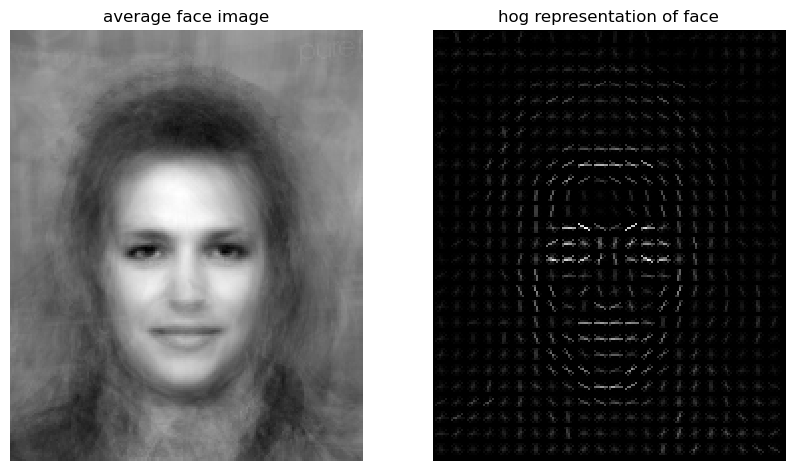

In [8]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')
list.sort(image_paths)
n = len(image_paths)
face_shape = io.imread('./face/'+image_paths[0], as_gray=True).shape
avg_face= np.zeros((face_shape))
for i,image_path in enumerate(image_paths):
    image = io.imread('./face/'+image_path, as_gray=True)
    avg_face = np.asarray(image)+np.asarray(avg_face)
avg_face = avg_face/n

(face_feature, face_hog) = hog_feature(avg_face)

plt.subplot(1,2,1)
plt.imshow(avg_face)
plt.axis('off')
plt.title('average face image')

plt.subplot(1,2,2)
plt.imshow(face_hog)
plt.title('hog representation of face')
plt.axis('off')

plt.show()


# Part 2: Sliding Window (1.5 points)
Implement **`sliding_window`** function to have windows slide across an image with a specific window size. The window slides through the image and check if an object is detected with a high score at every location. These scores will generate a response map and you will be able to find the location of the window with the highest hog score. 


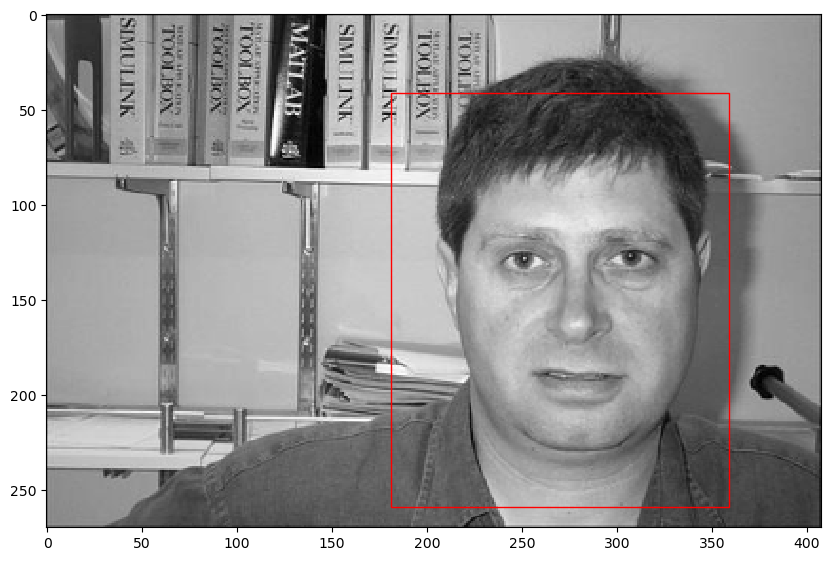

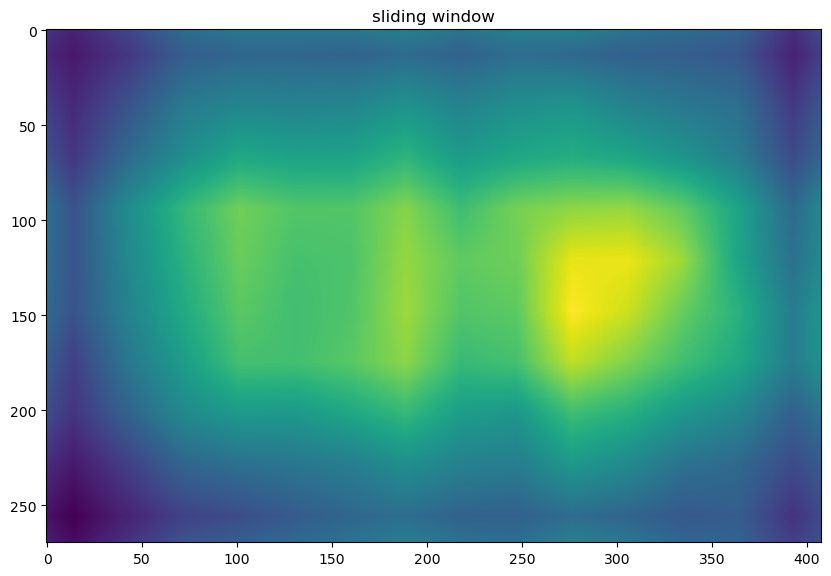

In [12]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 0.8)

(hogFeature, hogImage) = hog_feature(image)

(winH, winW) = face_shape
(score, r, c, response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)
crop = image[r:r+winH, c:c+winW]

fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((c,r),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(response_map,cmap='viridis', interpolation='nearest')
plt.title('sliding window')
plt.show()



Sliding window successfully found the human face in the above example. However, in the cell below, we are only changing the scale of the image, and you can see that sliding window does not work once the scale of the image is changed. 

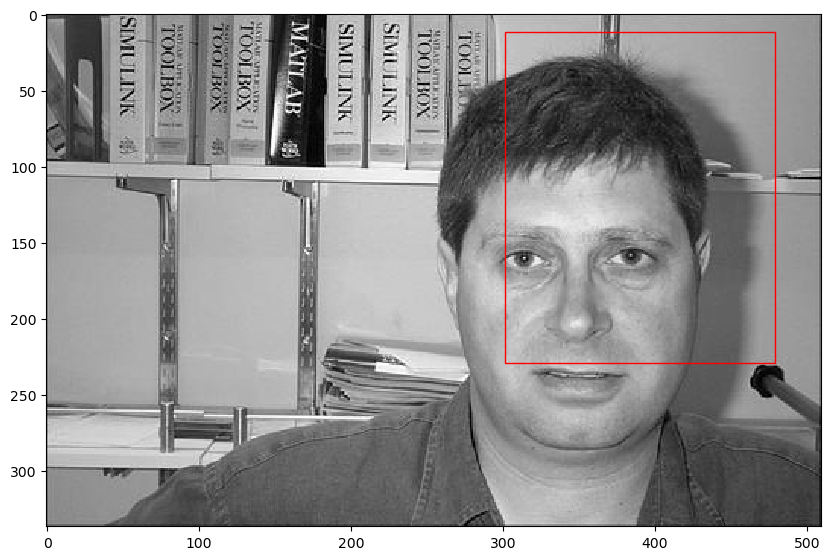

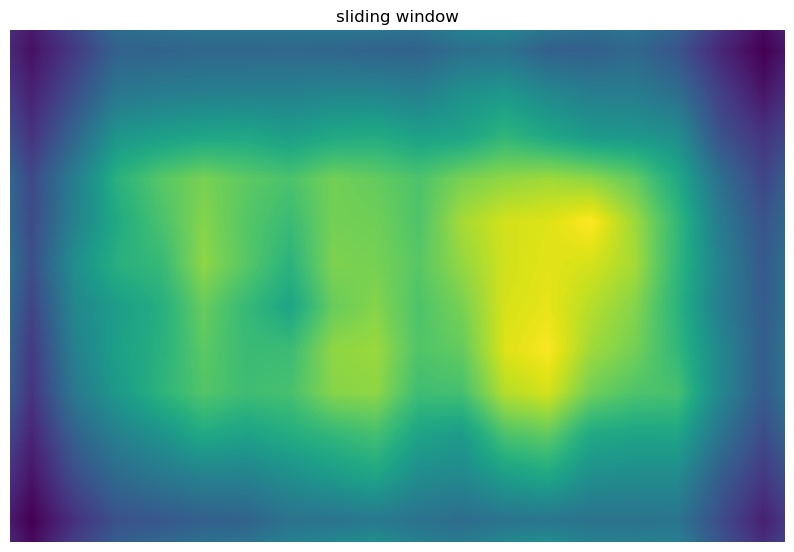

In [14]:
image_path = 'image_0001.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)


(winH, winW) = face_shape
(score, r, c, max_response_map) = sliding_window(image, face_feature, stepSize=30, windowSize=face_shape)

crop = image[r:r+winH, c:c+winW]

fig,ax = plt.subplots(1)
ax.imshow(image)
rect = patches.Rectangle((c,r),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.title('sliding window')
plt.axis('off')
plt.show()


# Part 3: Image Pyramids (1.5 points)
In order to make sliding window work for different scales of images, you need to implement image pyramids where you resize the image to different scales and run the sliding window method on each resized image. This way you scale the objects and can detect both small and large objects. 


###  3.1 Image Pyramid (0.5 point)

Implement **`pyramid`** function in `detection.py`, this will create pyramid of images at different scales. Run the following code, and you will see the shape of the original image gets smaller until it reaches a minimum size.


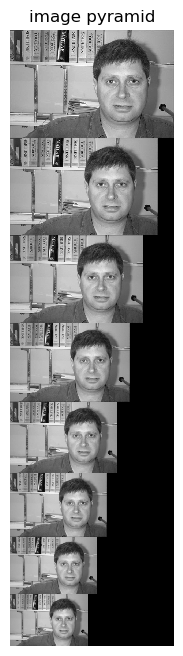

In [16]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

images = pyramid(image, scale = 0.9)
sum_r = 0
sum_c = 0
for i,result in enumerate(images):
    (scale, image) = result
    if (i==0):
        sum_c = image.shape[1]
    sum_r+=image.shape[0]

composite_image = np.zeros((sum_r, sum_c))

pointer = 0
for i, result in enumerate(images):
    (scale, image) = result   
    composite_image[pointer:pointer+image.shape[0], :image.shape[1]] = image
    pointer+= image.shape[0]
    
plt.imshow(composite_image)
plt.axis('off')
plt.title('image pyramid')
plt.show()


###  3.2 Pyramid Score (0.5 points)

After getting the image pyramid, we will run sliding window on all the images to find a place that gets the highest score. Implement **`pyramid_score`** function in `detection.py`. It will return the highest score and its related information in the image pyramids.

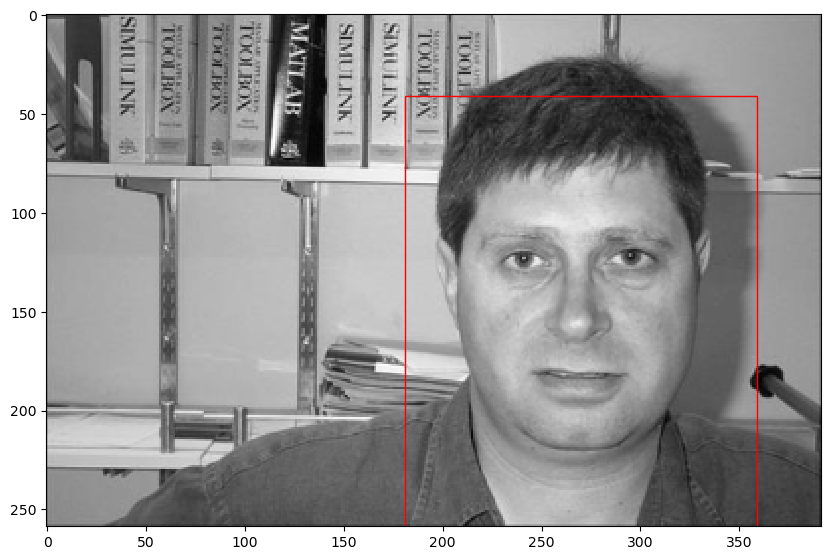

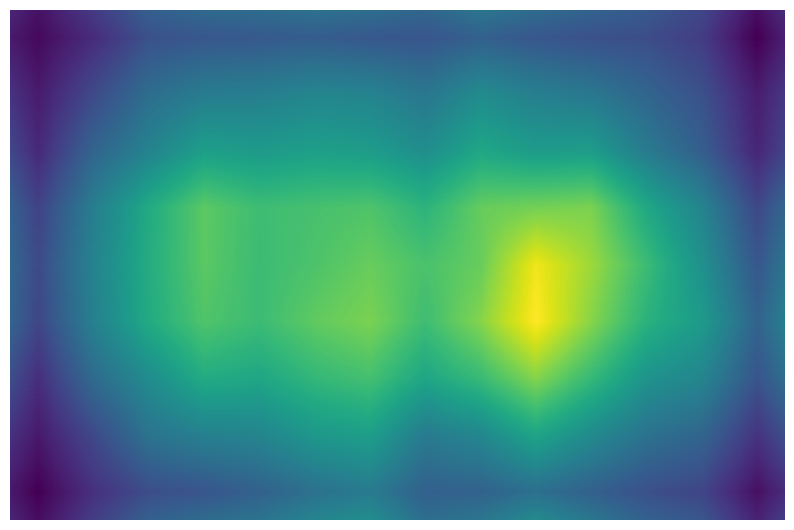

In [18]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

(winH, winW) = face_shape
max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
        (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

From the above example, we can see that image pyramid has fixed the problem of scaling. Then in the example below, we will try another image.

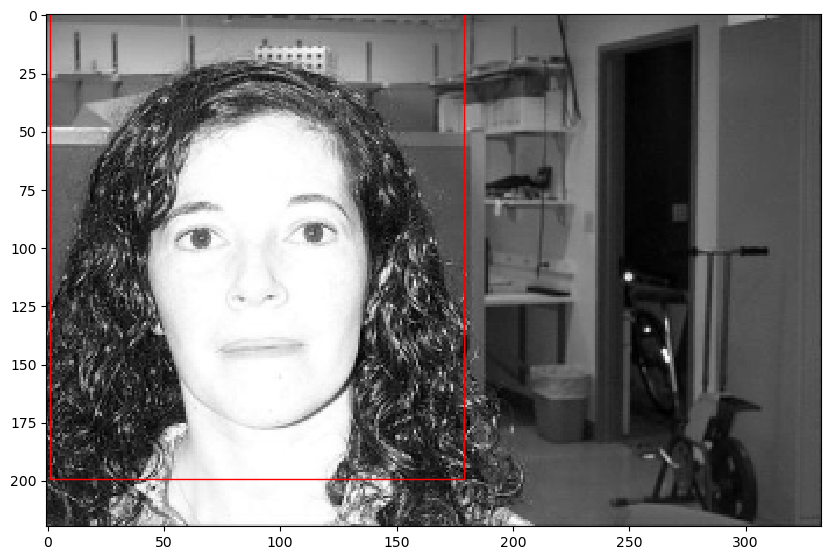

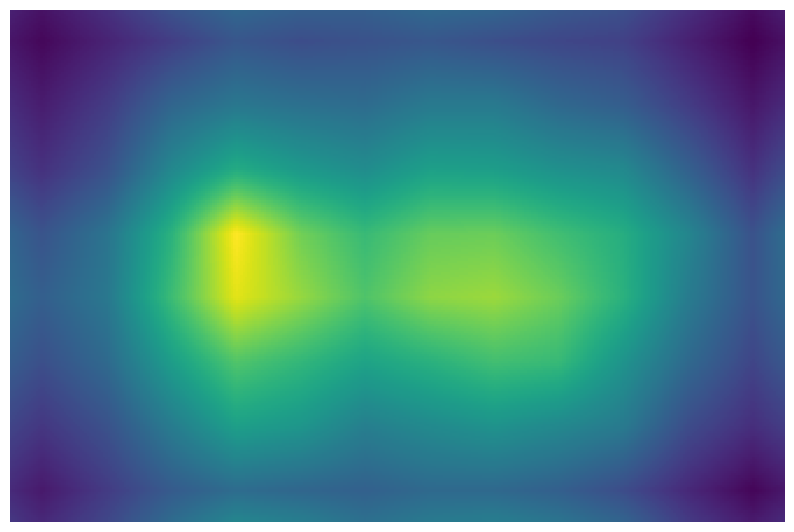

In [20]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
    (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()
    

Again, we can also detect the face successfully. Then, how about this image?

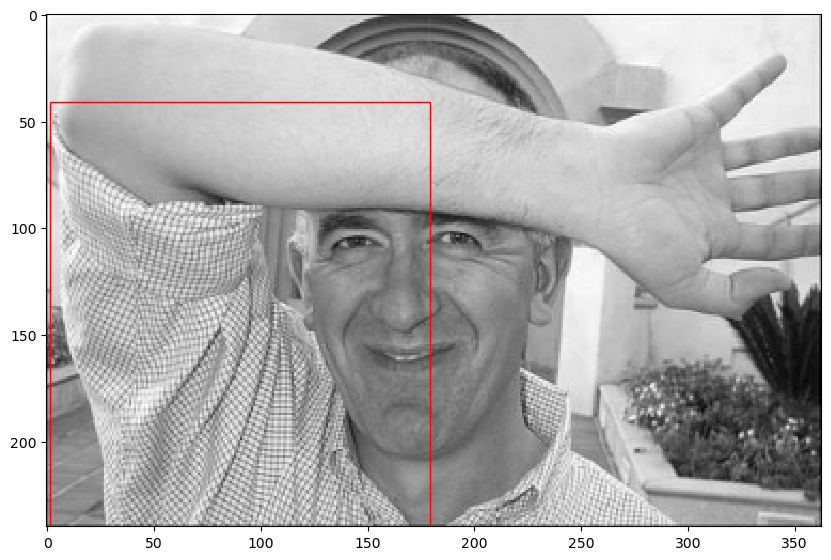

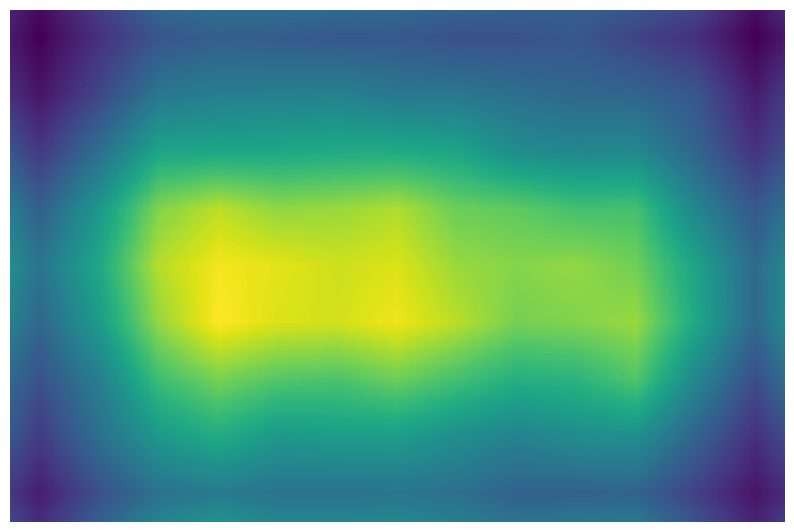

In [22]:
image_path = 'image_0319.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
    (image, face_feature, face_shape, stepSize = 30, scale=0.8)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

plt.imshow(max_response_map,cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.show()

### 3.3 Question (0.5 point)

Seems that the face in the above example is not detected correctly anymore. What is the problem here? Suggest at least one approach to solve this problem.

**Your Answer:** The face in the image has excessive details and is not the most outstanding object in the picture. To address this issue, there are several possible solutions. One is to employ a more advanced classifier for detecting the face. Another is to use a more sophisticated feature representation to portray the face. Alternatively, we could detect each component of the face individually and then merge them to reconstruct the entire face.

# Part 4: Face recognition (1.5 points)

In this task, we will use a dataset of faces of celebrities stored in `\celebrities_faces` folder. Each class has 50 training images and 10 testing images.

In [23]:
from utils_knn import load_dataset

X_train, y_train, classes_train = load_dataset('celebrities_faces', train=True, as_gray=True)
X_test, y_test, classes_test = load_dataset('celebrities_faces', train=False, as_gray=True)

assert classes_train == classes_test
classes = classes_train

print('Class names:', classes)
print('Training data shape:', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape: ', y_test.shape)

Class names: ['angelina jolie', 'anne hathaway', 'barack obama', 'brad pitt', 'cristiano ronaldo', 'emma watson', 'george clooney', 'hillary clinton', 'jennifer aniston', 'johnny depp', 'justin timberlake', 'leonardo dicaprio', 'natalie portman', 'nicole kidman', 'scarlett johansson', 'tom cruise']
Training data shape: (800, 64, 64)
Training labels shape:  (800,)
Test data shape: (160, 64, 64)
Test labels shape:  (160,)


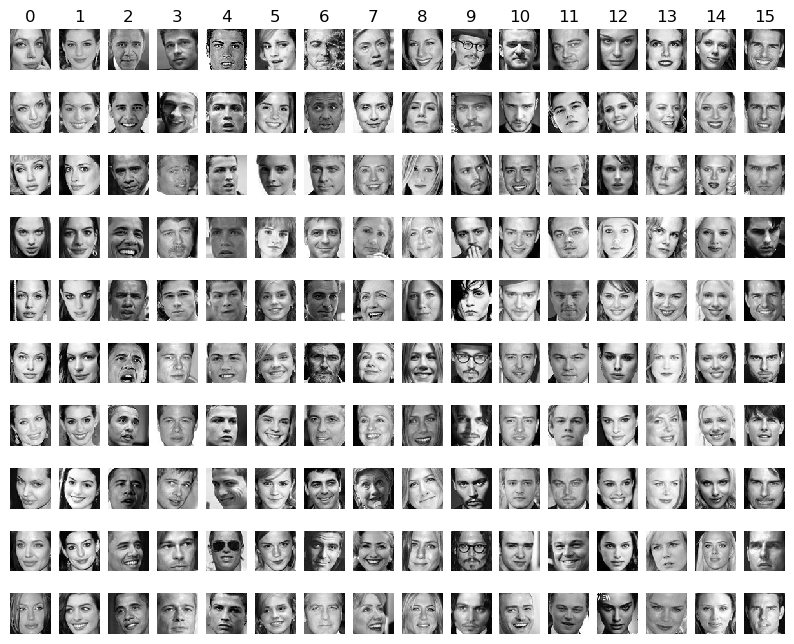

In [24]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

We're now going to try to classify the test images using the k-nearest neighbors (KNN) algorithm on the **HoG features of the images**. The aim of the KNN algorithm is to predict a test image's class based on which classes the k nearest train images belong to.  For example, using k = 3, if we found that for test image X, the three nearest train images were 2 pictures of Angelina Jolie, and one picture of Audrey Hepburn, we would predict that the test image X is a picture of Angelina Jolie.

Here are the steps that we will follow:
     1. We compute the L2 distances between every element of X_test and every element of X_train in `compute_distances`.
     2. We split the dataset into 5 folds for cross-validation in `split_folds`.
     3. For each fold, and for different values of `k`, we predict the labels and measure accuracy.
     4. Using the best `k` found through cross-validation, we measure accuracy on the test set.
Please refer this resource for better understanding cross-validation: https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f

In [26]:
# Create HOG datasets
X_train_hog = [hog_feature(x)[0] for x in X_train]
X_test_hog = [hog_feature(x)[0] for x in X_test]
print("Loaded {} HoG features.".format(len(X_train_hog)))
print("Loaded {} HoG features.".format(len(X_test_hog)))

X_train_hog = np.stack(X_train_hog)
X_test_hog = np.stack(X_test_hog)
print("HOG Training data shape:", X_train_hog.shape)
print("HOG Test data shape:", X_test_hog.shape)

Loaded 800 HoG features.
Loaded 160 HoG features.
HOG Training data shape: (800, 2916)
HOG Test data shape: (160, 2916)


Implement `compute_distances`, `predict_labels`, and `split_folds` functions in `k_nearest_neighbor.py`

In [30]:
from k_nearest_neighbor import *

# Compute the distances between all features from X_train and from X_test
dists = compute_distances(X_test_hog, X_train_hog)
assert dists.shape == (160, 800)
print("dists shape:", dists.shape)

# We use k = 1 (which corresponds to only taking the nearest neighbor to decide)
y_test_pred = predict_labels(dists, y_train, k=1)

# Compute and print the fraction of correctly predicted examples
num_test = y_test.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

dists shape: (160, 800)
Got 75 / 160 correct => accuracy: 0.468750


### Cross-validation

We don't know the best value for our parameter `k`.
There is no theory on how to choose an optimal `k`, and the way to choose it is through cross-validation.

We cannot compute any metric on the test set to choose the best k, because we want our final test accuracy to reflect a real use case. This real use case would be a setting where we have new examples come and we classify them on the go. There is no way to check the accuracy beforehand on that set of test examples to determine `k`.

Cross-validation will make use split the data into different fold (5 here). For each fold, if we have a total of 5 folds we will have: 80% of the data as training data and 20% of the data as validation data. 

We will compute the accuracy on the validation accuracy for each fold, and use the mean of these 5 accuracies to determine the best parameter `k`.

Running for k=5
Running for k=10
Running for k=15
Running for k=20
Running for k=25
Running for k=30
Running for k=35
Running for k=40
Running for k=45
Running for k=50
Running for k=55
Running for k=60
Running for k=65
Running for k=70
Running for k=75
Running for k=80
Running for k=85
Running for k=90
Running for k=95
Running for k=100


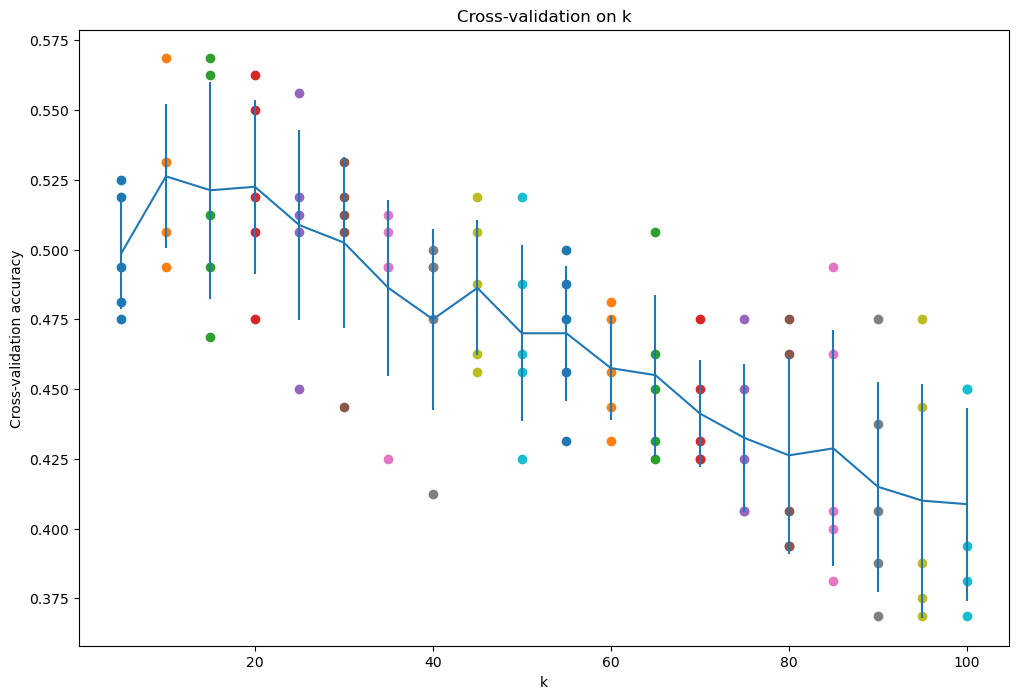

In [31]:
# Create Cross Validation datasets
num_folds = 5
X_hog_trains, y_trains, X_hog_vals, y_vals = split_folds(X_train_hog, y_train, num_folds)

    
# List of k to choose from
k_choices = list(range(5, 101, 5))
k_to_accuracies = {}

for k in k_choices:
    print("Running for k=%d" % k)
    accuracies = []
    for i in range(num_folds):
        # Make predictions
        fold_dists = compute_distances(X_hog_vals[i], X_hog_trains[i])
        y_pred = predict_labels(fold_dists, y_trains[i], k)

        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_pred == y_vals[i])
        accuracy = float(num_correct) / len(y_vals[i])
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies
    
    
# plot the raw observations
plt.figure(figsize=(12,8))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [32]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 50% accuracy on the test data.

best_k = None
### YOUR CODE HERE
# Choose the best k based on the cross validation above
best_k = k_choices[np.argmax(accuracies_mean)]
### END YOUR CODE

dists = compute_distances(X_test_hog, X_train_hog)
y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_test = X_test_hog.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('For k = %d, got %d / %d correct => accuracy: %f' % (best_k, num_correct, num_test, accuracy))

For k = 10, got 90 / 160 correct => accuracy: 0.562500


### Question

How did you decide which value of `k` was 'best'? In a real-world scenario, if you were deploying this K-Nearest Neighbors HOG feature classifier, how would you consider the roles of the mean, standard deviation, maximum, and
or minimum of each value of k that you observed in cross validation when choosing the 'best' `k`?

**Your Answer:** We decide the best value of k using cross validation accuracy. The code decides the value of k with the most correct mean accuracy by calculating the average accuracy of the classifier for every value of k over the cross validation folds.

In a real world scenario, the choice of K will be problem-specific. That is, k depends on the problem that is to be solved and other factors such as available dataset, computational resources, etc.

Also, mean, standard deviation, maximum or minimum value of k helps to provide more information on how the model behaves and how sensitive it is to different k values. They help us in choosing the correct k values and in understanding the effect of our hyperparameter on the performance of our model

**Credit**: Juan Carlos Niebles and Ranjay Krishna